In [1]:
import os
import scenicplus
import scanpy as sc
import warnings
import pandas as pd
import matplotlib as mpl
import pickle
import dill
import sys

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

work_dir = '/data/leuven/345/vsc34561/ibp-2022-data/'
rnaseq_dir = work_dir + 'sn_rna_seq/'
rnaseq_output = rnaseq_dir + 'processed/'
atacseq_dir = work_dir + 'sn_atac_seq/'
state_dir = work_dir + 'state/'
archive_dir = state_dir + 'archive/'
local_state_dir = '/data/leuven/338/vsc33838/mirror/state'
motif_path = '/data/leuven/338/vsc33838/mirror/state/motifs/'
scratch_dir = os.getenv('VSC_SCRATCH')

In [2]:
adata = sc.read_h5ad(os.path.join(state_dir, 'alzheimers.h5ad'))
cistopic_obj = dill.load(open(os.path.join(state_dir, 'cistopic_obj.pkl'), 'rb'))
menr = dill.load(open(os.path.join(motif_path, 'menr.pkl'), 'rb'))

In [3]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata, #.raw.to_adata(),
    cisTopic_obj = cistopic_obj,
    menr = menr,
    multi_ome_mode = False,
    key_to_group_by = 'celltype',
    nr_cells_per_metacells = 5)

2022-11-12 10:41:51,920 cisTopic     INFO     Imputing drop-outs
2022-11-12 10:42:33,012 cisTopic     INFO     Scaling
2022-11-12 10:43:30,724 cisTopic     INFO     Keep non zero rows
2022-11-12 10:44:41,765 cisTopic     INFO     Imputed accessibility sparsity: 0.7658145431815311
2022-11-12 10:44:41,769 cisTopic     INFO     Create CistopicImputedFeatures object
2022-11-12 10:44:41,770 cisTopic     INFO     Making matrix sparse
2022-11-12 10:50:34,610 cisTopic     INFO     Done!
2022-11-12 10:50:34,843 create scenicplus object INFO     Following annotations were found in both assays under key celltype:
	INH, ODC, MG, PER.END, OPC, EX, ASC.
Keeping 60082 cells for RNA and 31142 for ATAC.
2022-11-12 10:51:57,295 create scenicplus object INFO     Automatically set `nr_metacells` to: ASC: 1860, EX: 594, INH: 532, MG: 1624, ODC: 6704, OPC: 358, PER.END: 132
2022-11-12 10:51:57,298 create scenicplus object INFO     Generating pseudo multi-ome data


In [12]:
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}

import pybiomart as pbm
def test_ensembl_host(scplus_obj, host, species):
    dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
    annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    annot['Chromosome'] = annot['Chromosome'].astype('str')
    filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
    annot = annot[~filter]
    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    gene_names_release = set(annot['Gene'].tolist())
    ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
    print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
    return ov

n_overlap = {}
for version in ensembl_version_dict.keys():
    print(f'host: {version}')
    try:
        n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'hsapiens')
    except:
        print('Host not reachable')
v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105
Genes recovered: 4561 out of 5354
host: 104
Genes recovered: 4590 out of 5354
host: 103
Genes recovered: 5188 out of 5354
host: 102


/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pybiomart/dataset.py:269: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(StringIO(response.text), sep='\t')


Genes recovered: 5196 out of 5354
host: 101
Genes recovered: 5208 out of 5354
host: 100
Host not reachable
host: 99
Genes recovered: 5230 out of 5354
host: 98
Genes recovered: 5265 out of 5354
host: 97
Genes recovered: 5274 out of 5354
host: 96
Genes recovered: 5305 out of 5354
host: 95
Genes recovered: 5336 out of 5354
host: 94
Genes recovered: 5352 out of 5354
host: 93
Genes recovered: 5295 out of 5354
host: 92
Genes recovered: 5285 out of 5354
host: 91
Genes recovered: 5242 out of 5354
host: 90
Genes recovered: 5221 out of 5354
host: 89
Host not reachable
host: 88
Host not reachable
host: 87
Host not reachable
host: 86
Host not reachable
host: 80
Genes recovered: 4502 out of 5354
host: 77
Genes recovered: 4426 out of 5354
host: 75
Host not reachable
host: 54
Host not reachable
version: 94 has the largest overlap, use http://oct2018.archive.ensembl.org/ as biomart host


In [4]:
biomart_host = "http://oct2018.archive.ensembl.org/"

In [5]:
# LAST TRY
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    sys.stderr = open(os.path.join(scratch_dir, 'err-final.log'), "w")
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['celltype'],
        species = 'hsapiens',
        assembly = 'hg38',
        tf_file = os.path.join(local_state_dir, 'TF_names_v_1.01.txt'),
        save_path = os.path.join(scratch_dir, 'scenicplus'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = True,
        calculate_DEGs_DARs = True,
        export_to_loom_file = True,
        export_to_UCSC_file = True,
        path_bedToBigBed = os.path.join(local_state_dir, 'bin'),
        n_cpu = 25,
        _temp_dir = os.path.join(scratch_dir, 'ray_spill'))
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(scratch_dir, 'scenicplus/scplus_obj_f.pkl'), 'wb'), protocol=-1)
    raise(e)

2022-11-11 23:05:25,101 SCENIC+_wrapper INFO     /scratch/leuven/338/vsc33838/scenicplus folder already exists.
2022-11-11 23:05:25,103 SCENIC+_wrapper INFO     Merging cistromes
2022-11-11 23:09:08,661 SCENIC+_wrapper INFO     Getting search space
2022-11-11 23:09:11,764 R2G          INFO     Downloading gene annotation from biomart dataset: hsapiens_gene_ensembl
2022-11-11 23:09:32,023 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
2022-11-11 23:09:33,552 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2022-11-11 23:09:35,726 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2022-11-11 23:09:52,818 R2G          INFO     Intersecting with regions.
2022-11-11 23:09:54,279 R2G          INFO     Calculating distances from region to gene
2022-11-

MemoryError: 

In [5]:
# LAST TRY
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    sys.stderr = open(os.path.join(scratch_dir, 'err-final-2.log'), "w")
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['celltype'],
        species = 'hsapiens',
        assembly = 'hg38',
        tf_file = os.path.join(local_state_dir, 'TF_names_v_1.01.txt'),
        save_path = os.path.join(scratch_dir, 'scenicplus'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = False,
        calculate_DEGs_DARs = False,
        export_to_loom_file = True,
        export_to_UCSC_file = True,
        path_bedToBigBed = os.path.join(local_state_dir, 'bin'),
        n_cpu = 25,
        _temp_dir = os.path.join(scratch_dir, 'ray_spill'))
except Exception as e:
    #in case of failure, still save the object
    # dill.dump(scplus_obj, open(os.path.join(scratch_dir, 'scenicplus/scplus_obj_f.pkl'), 'wb'), protocol=-1)
    raise(e)

2022-11-12 11:00:52,665 SCENIC+_wrapper INFO     Created folder : /scratch/leuven/338/vsc33838/scenicplus
2022-11-12 11:00:52,666 SCENIC+_wrapper INFO     Merging cistromes
2022-11-12 11:04:34,490 SCENIC+_wrapper INFO     Getting search space
2022-11-12 11:04:37,177 R2G          INFO     Downloading gene annotation from biomart dataset: hsapiens_gene_ensembl
2022-11-12 11:04:51,823 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
2022-11-12 11:04:53,348 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2022-11-12 11:04:55,473 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2022-11-12 11:05:12,442 R2G          INFO     Intersecting with regions.
2022-11-12 11:05:13,863 R2G          INFO     Calculating distances from region to gene
2022-11-12 11:

# Checkpoint

In [7]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 11804 x 5354 and n_cells x n_regions = 11804 x 820223
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
	metadata_cell:'celltype'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

In [ ]:
import dill
scplus_obj = dill.load(open(os.path.join(scratch_dir, 'scenicplus/scplus_obj.pkl'), 'rb'))

# Downstream Analysis

In [8]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)
scplus_obj.uns['eRegulon_metadata_filtered'].head()

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,ARID3A_+_(226r),ARID3A_+_(187g),ARID3A,False,chr15:51621883-51622383,LYSMD2,0.020511,0.191786,0.003934,0.003934,1.287438,1,0.121103,0.155912,0.155912,ARID3A_+_+
1,ARID3A_+_(226r),ARID3A_+_(187g),ARID3A,False,chr15:51649817-51650317,LYSMD2,0.015708,0.149838,0.002354,0.002354,1.287438,1,0.121103,0.155912,0.155912,ARID3A_+_+
2,ARID3A_+_(226r),ARID3A_+_(187g),ARID3A,False,chr2:102449332-102449832,IL18R1,0.073774,0.222023,0.016380,0.016380,2.754337,1,0.119046,0.327893,0.327893,ARID3A_+_+
3,ARID3A_+_(226r),ARID3A_+_(187g),ARID3A,False,chr1:156090109-156090609,LAMTOR2,0.028750,0.154365,0.004438,0.004438,3.985431,1,0.088093,0.351087,0.351087,ARID3A_+_+
4,ARID3A_+_(226r),ARID3A_+_(187g),ARID3A,False,chr1:155909833-155910333,LAMTOR2,0.020537,0.055416,0.001138,0.001138,3.985431,1,0.088093,0.351087,0.351087,ARID3A_+_+


In [11]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(scratch_dir, 'scenicplus/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(scratch_dir, 'scenicplus/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

In [123]:
scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'eRegulon_AUC_thresholds', 'RSS', 'eRegulon_metadata_filtered', 'eRegulon_signatures_filtered', 'eRegulon_AUC_filtered', 'Pseudobulk', 'TF_cistrome_correlation', 'selected_eRegulon'])

In [45]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 11804 x 5354 and n_cells x n_regions = 11804 x 820223
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
	metadata_cell:'celltype'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

In [124]:
scplus_obj.uns['eRegulons'][0:5]

[eRegulon for TF ARID3A in context frozenset({'Top 10 region-to-gene links per gene', 'positive tf2g', 'positive r2g', 'Cistromes_Unfiltered'}).
 	This eRegulon has 226 target regions and 187 target genes.,
 eRegulon for TF ARNTL in context frozenset({'Top 5 region-to-gene links per gene', 'Top 15 region-to-gene links per gene', 'positive tf2g', 'BASC binarized', '0.9 quantile', 'Top 10 region-to-gene links per gene', '0.85 quantile', 'positive r2g', 'Cistromes_Unfiltered'}).
 	This eRegulon has 61 target regions and 54 target genes.,
 eRegulon for TF ASCL1 in context frozenset({'Top 5 region-to-gene links per gene', 'Top 15 region-to-gene links per gene', 'positive tf2g', '0.95 quantile', 'BASC binarized', '0.9 quantile', 'Top 10 region-to-gene links per gene', '0.85 quantile', 'positive r2g', 'Cistromes_Unfiltered'}).
 	This eRegulon has 1328 target regions and 335 target genes.,
 eRegulon for TF ATF3 in context frozenset({'Top 5 region-to-gene links per gene', 'Top 15 region-to-gene

In [125]:
for attr in dir(scplus_obj.uns['eRegulons'][0]):
    if not attr.startswith('_'):
        print(f"{attr}: {getattr(scplus_obj.uns['eRegulons'][0], attr) if not type(getattr(scplus_obj.uns['eRegulons'][0], attr)) == list else getattr(scplus_obj.uns['eRegulons'][0], attr)[0:5]}")


cistrome_name: ARID3A_(26066r)
context: frozenset({'Top 10 region-to-gene links per gene', 'positive tf2g', 'positive r2g', 'Cistromes_Unfiltered'})
gsea_adj_pval: None
gsea_enrichment_score: None
gsea_pval: None
in_leading_edge: None
is_extended: False
n_target_genes: 187
n_target_regions: 226
regions2genes: [r2g(region='chr15:51621883-51622383', target='LYSMD2', importance=0.020511412064102435, rho=0.19178590698064324, importance_x_rho=0.003933799766167593, importance_x_abs_rho=0.003933799766167593), r2g(region='chr2:102449332-102449832', target='IL18R1', importance=0.07377410855119035, rho=0.22202348557268076, importance_x_rho=0.016379584725552593, importance_x_abs_rho=0.016379584725552593), r2g(region='chr1:156090109-156090609', target='LAMTOR2', importance=0.028749639344621054, rho=0.1543650658108639, importance_x_rho=0.004437939969471031, importance_x_abs_rho=0.004437939969471031), r2g(region='chr9:70044462-70044962', target='MAMDC2', importance=0.07122544660063534, rho=0.4390411

In [77]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based',
        nr_cells = 100,
        nr_pseudobulks = 10)
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based',
        nr_cells = 100,
        nr_pseudobulks = 10)

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

In [78]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']

0       KLF2_extended_+_(600r)
1       KLF12_extended_-_(37r)
2               ZBTB18_-_(16r)
3                 CREM_-_(27r)
4                 MAF_-_(250r)
                ...           
133            RUNX1_+_(1651r)
134    ARID5A_extended_+_(39r)
135              STAT1_-_(32r)
136              HIF1A_-_(44r)
137              EPAS1_+_(17r)
Name: Cistrome, Length: 138, dtype: object

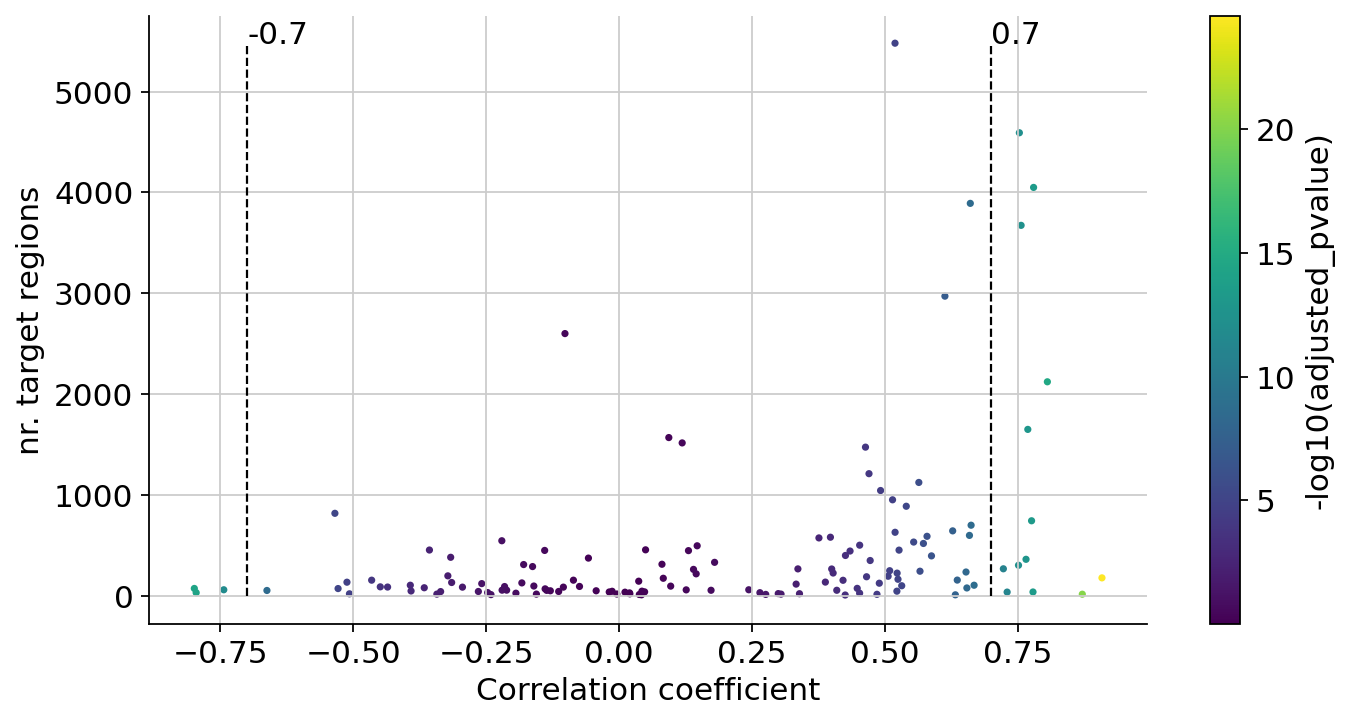

In [79]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.7, 0.70],
        'n_targets': 0
}
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [80]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 16 eRegulons


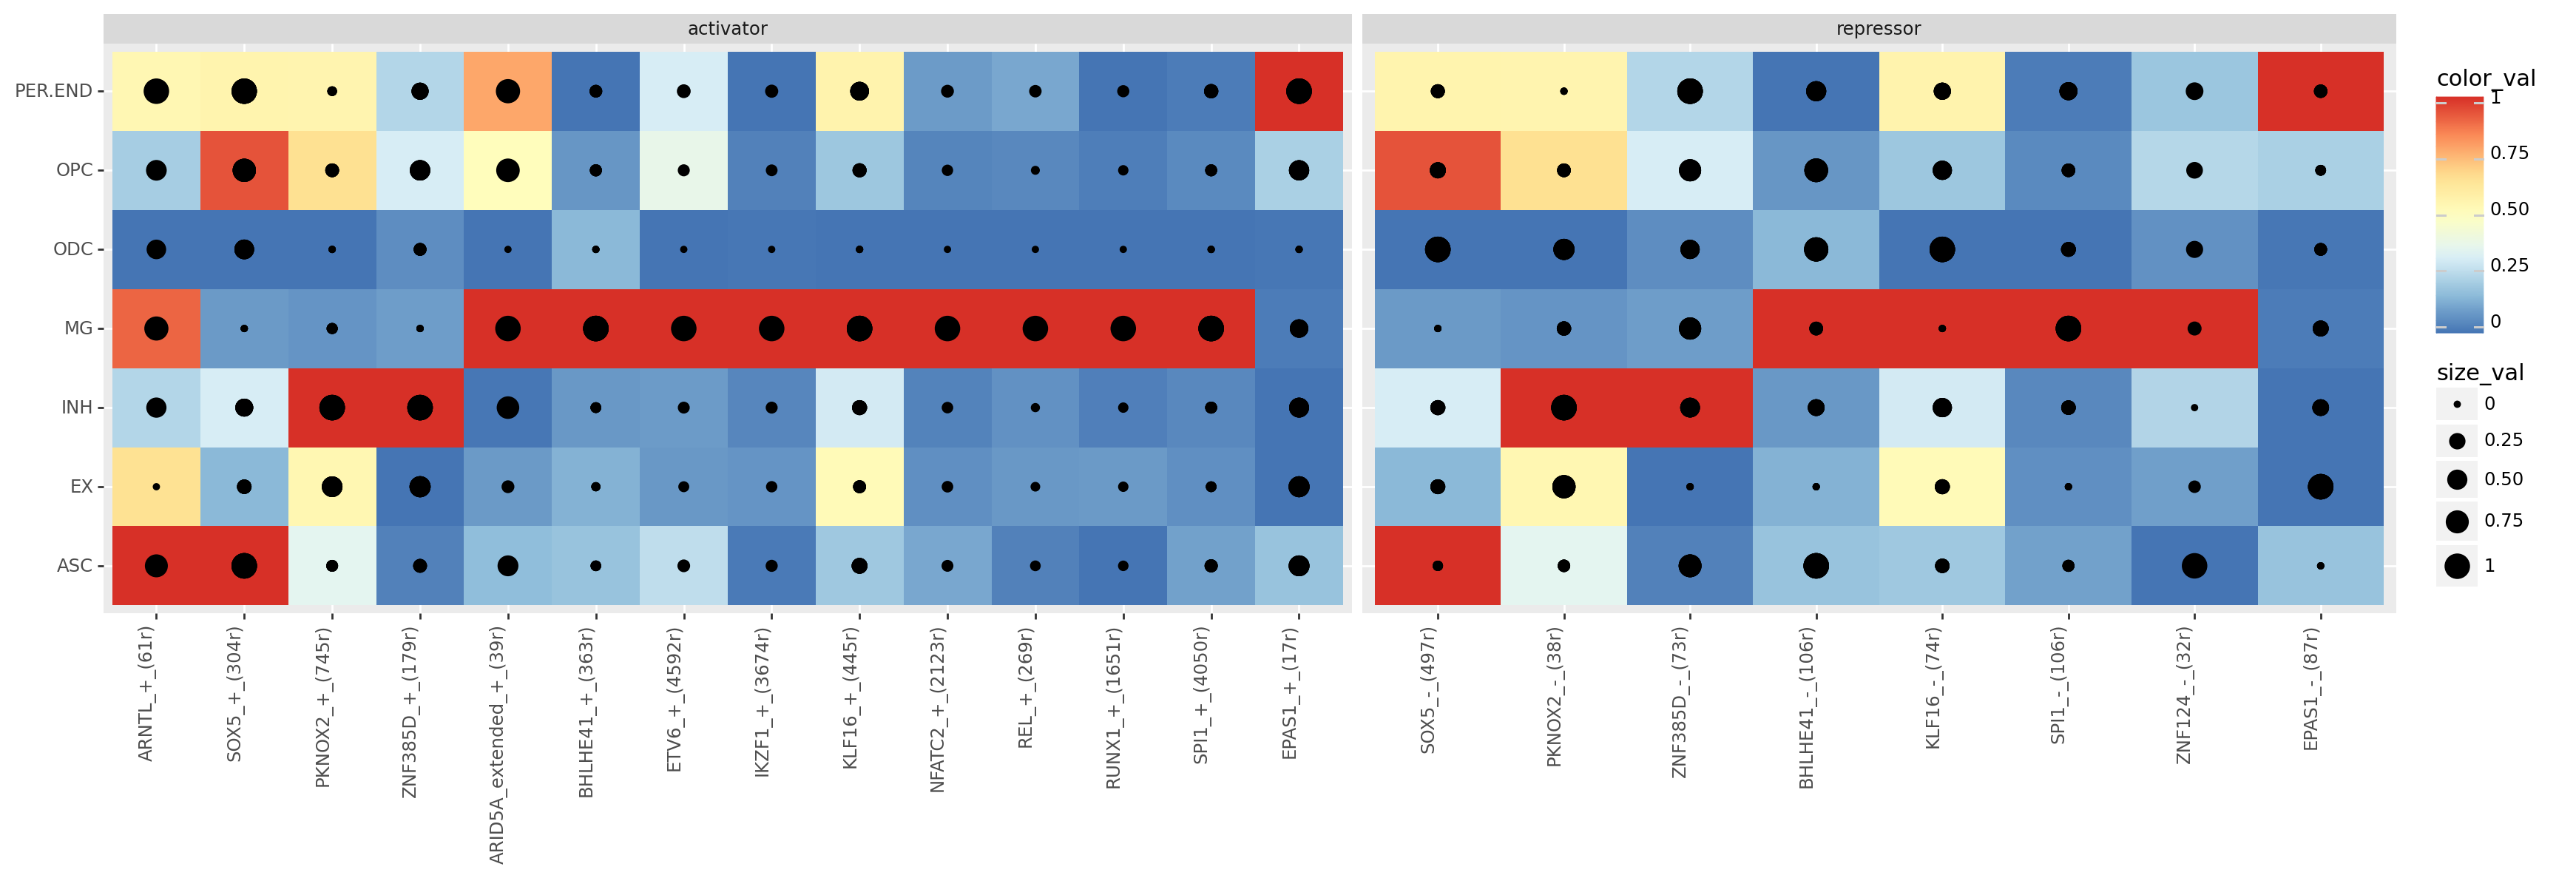

<ggplot: (1443876240999)>

In [81]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'celltype',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
        # index_order = ['MM001', 'MM011', 'MM031', 'MM087', 'MM074', 'MM057', 'MM047', 'MM029', 'MM099'],
        figsize = (20, 5),
        orientation = 'horizontal')

In [ ]:
from scenicplus.cistromes import prune_plot
# Region based
%matplotlib inline
import seaborn as sns
sns.set_style("white")
colors = ["#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF"]
categories = sorted(set(scplus_obj.metadata_cell['celltype']))
color_dict = dict(zip(categories, colors[0:len(categories)]))
prune_plot(scplus_obj,
           'BCL11A_+_(657r)',
           pseudobulk_variable = 'celltype',
           show_dot_plot = True,
           show_line_plot = False,
           color_dict = color_dict,
           use_pseudobulk = True,
           auc_key = 'eRegulon_AUC_filtered',
           signature_key = 'Region_based',
           seed=555)

In [ ]:
# Gene based
%matplotlib inline
sns.set_style("white")
colors = ["#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF"]
categories = sorted(set(scplus_obj.metadata_cell['celltype']))
color_dict = dict(zip(categories, colors[0:len(categories)]))
prune_plot(scplus_obj,
           'SOX5_-_(304r)',
           pseudobulk_variable = 'celltype',
           show_dot_plot = True,
           show_line_plot = False,
           color_dict = color_dict,
           use_pseudobulk = True,
           auc_key = 'eRegulon_AUC_filtered',
           signature_key = 'Gene_based',
           seed=555)

In [ ]:
from scenicplus.plotting.correlation_plot import *
correlation_heatmap(scplus_obj,
                    auc_key = 'eRegulon_AUC_filtered',
                    signature_keys = ['Gene_based'],
                    selected_regulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
                    fcluster_threshold = 0.1,
                    fontsize = 6)

In [ ]:
#from scenicplus.plotting.correlation_plot import *
jaccard_heatmap(scplus_obj,
                    gene_or_region_based = 'Gene_based',
                    signature_key = 'eRegulon_signatures_filtered',
                    selected_regulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
                    fcluster_threshold = 0.1,
                    fontsize = 3,
                    method='intersect')

In [122]:
scplus_obj.uns['selected_eRegulon']

{'Gene_based': ['NFATC2_+_(658g)',
  'BHLHE41_+_(242g)',
  'KLF16_-_(27g)',
  'PKNOX2_-_(21g)',
  'SOX5_+_(170g)',
  'REL_+_(212g)',
  'ZNF385D_+_(122g)',
  'ETV6_+_(954g)',
  'PKNOX2_+_(294g)',
  'ARNTL_+_(54g)',
  'SPI1_+_(820g)',
  'ZNF124_-_(30g)',
  'IKZF1_+_(749g)',
  'RUNX1_+_(634g)',
  'ARID5A_extended_+_(40g)',
  'EPAS1_+_(17g)'],
 'Region_based': ['NFATC2_+_(2123r)',
  'BHLHE41_+_(363r)',
  'KLF16_-_(74r)',
  'PKNOX2_-_(38r)',
  'SOX5_+_(304r)',
  'REL_+_(269r)',
  'ZNF385D_+_(179r)',
  'ETV6_+_(4592r)',
  'PKNOX2_+_(745r)',
  'ARNTL_+_(61r)',
  'SPI1_+_(4050r)',
  'ZNF124_-_(32r)',
  'IKZF1_+_(3674r)',
  'RUNX1_+_(1651r)',
  'ARID5A_extended_+_(39r)',
  'EPAS1_+_(17r)']}

In [126]:
dill.dump(scplus_obj, open(os.path.join(scratch_dir, 'scenicplus/scplus_obj_pseudo.pkl'), 'wb'), protocol=-1)
